In [8]:
import sys
import os

# Manually specify the parent directory
sys.path.append(os.path.abspath(".."))

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import scanpy as sc
import anndata


from src.MOSAICFlow.physical import physical_align

# Some helper functions needed for generating simulation data and visualization

In [13]:
# Define a function to check if a point is inside a circle
def inside_circle(x, y, center, radius):
    return (x - center[0])**2 + (y - center[1])**2 < radius**2
# Define a function to check if a point is inside an ellipse
def inside_ellipse(x, y, center, a, b):
    return ((x - center[0]) / a)**2 + ((y - center[1]) / b)**2 < 1

def distance_to_circle(point, center, radius):
    # Euclidean distance from point to circle center, minus the radius
    dist = np.linalg.norm(np.array(point) - np.array(center)) - radius
    return max(dist, 0)  # Distance is zero if point is inside the circle

def distance_to_ellipse(point, center, semi_major_axis, semi_minor_axis):
    # Vector from ellipse center to the point
    px, py = point[0] - center[0], point[1] - center[1]
    
    # Angle to the center of ellipse
    angle = np.arctan2(py, px)
    
    # Closest point on the ellipse boundary
    ex = center[0] + semi_major_axis * np.cos(angle)
    ey = center[1] + semi_minor_axis * np.sin(angle)
    
    # Euclidean distance to closest point on the ellipse boundary
    return np.linalg.norm(np.array(point) - np.array([ex, ey]))

# Convert cartesian coordinate to polar coordinate. Used for converting between modalities.
def cartesian_to_spherical(vec):
    x, y = vec
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return np.array([r, theta])

# Function to apply the Möbius transformation
def mobius_transform(x, y, a, b, c, d):
    # Convert x, y to complex number z
    z = x + 1j * y
    # Apply the transformation: f(z) = (az + b) / (cz + d)
    transformed_z = (a * z + b) / (c * z + d)
    return transformed_z.real, transformed_z.imag

def rotate_points(points, angle_degrees):
    """
    Rotates a 2D point cloud counterclockwise by a given angle.

    Parameters:
    points (numpy.ndarray): A N x 2 array representing N points in 2D.
    angle_degrees (float): The angle to rotate the points, in degrees.

    Returns:
    numpy.ndarray: A N x 2 array of rotated points.
    """
    # Convert angle from degrees to radians
    angle_radians = np.radians(angle_degrees)

    # Create the 2D rotation matrix
    rotation_matrix = np.array([
        [np.cos(angle_radians), -np.sin(angle_radians)],
        [np.sin(angle_radians), np.cos(angle_radians)]
    ])

    # Apply the rotation matrix to the points
    rotated_points = np.dot(points, rotation_matrix.T)

    return rotated_points


def affine_transform(X, T):
    homogeneous_X = np.vstack([X.T, np.ones((1, X.shape[0]))])
    transformed_homogeneous_X = T @ homogeneous_X
    return transformed_homogeneous_X[:2, :].T

def plot_slices_overlap(slices, colors, invert_axis=True, s=10):
    plt.figure()
    for i in range(len(slices)):
        plt.scatter(slices[i][:,0],slices[i][:,1],marker=".", s=s, color=colors[i])
    if invert_axis:
        plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()

# Generate simulated slices

We first generate the square grid and two feature modalities, which serve as the basis for generating a stack of five slices using Mobius transformation

In [15]:
# Parameters for simulation
grid_size = 100
center_circle = (25, 25)
radius_circle = 15
center_ellipse = (75, 75)
semi_major_axis = 20
semi_minor_axis = 10
dropout = 0.3

# Point coordinates and multimodal features
points = []
features_dist = []
features_spa = []

for x in range(grid_size):
    for y in range(grid_size):
        if not inside_circle(x,y,center_circle,radius_circle) and not inside_ellipse(x,y,center_ellipse,semi_major_axis,semi_minor_axis):
            if random.random() > dropout:
                points.append([x, y])
                feature_dist = min(distance_to_circle([x,y],center_circle,radius_circle),distance_to_ellipse([x,y],center_ellipse,semi_major_axis,semi_minor_axis))
                feature_spa = x + y
                features_dist.append(feature_dist)
                features_spa.append(feature_spa)
            
# This is the location coordinates of the square grid
points = np.array(points)
# This is the two feature modalities on the square grid
features_dist = np.array(features_dist) / np.max(features_dist)
features_spa = np.array(features_spa) / np.max(features_spa)
features_modality1 = np.stack((features_dist, features_spa),axis=1)
features_modality2 = []
for i in range(features_modality1.shape[0]):
    features_modality2.append(cartesian_to_spherical(features_modality1[i]))
features_modality2 = np.array(features_modality2)

Then, we apply Mobius transformations to the square grid, which results in five different simulated slices. We interleave data modalities so each pair of adjacent slices come from different feature modalities.

/tmp/ipykernel_2761116/4084228309.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  slice_adata = anndata.AnnData(X=features)


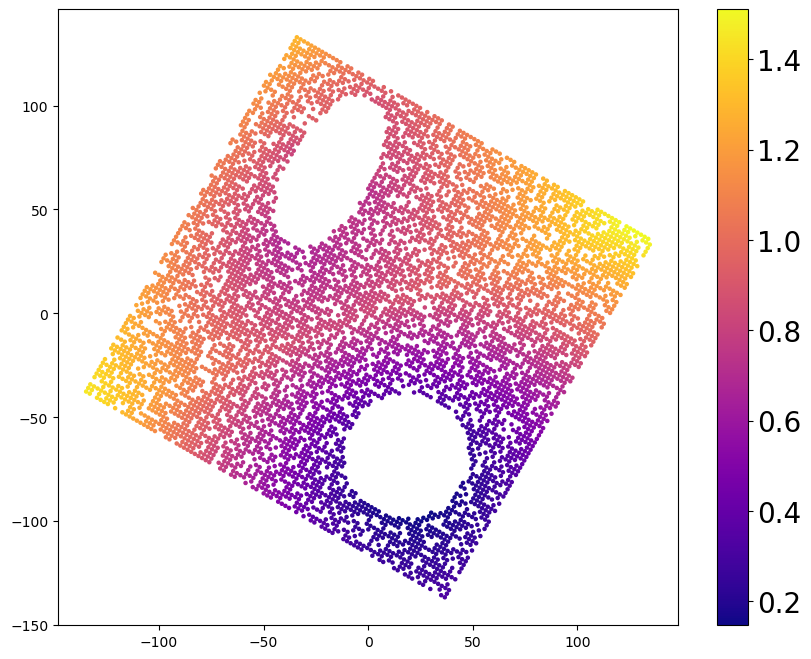

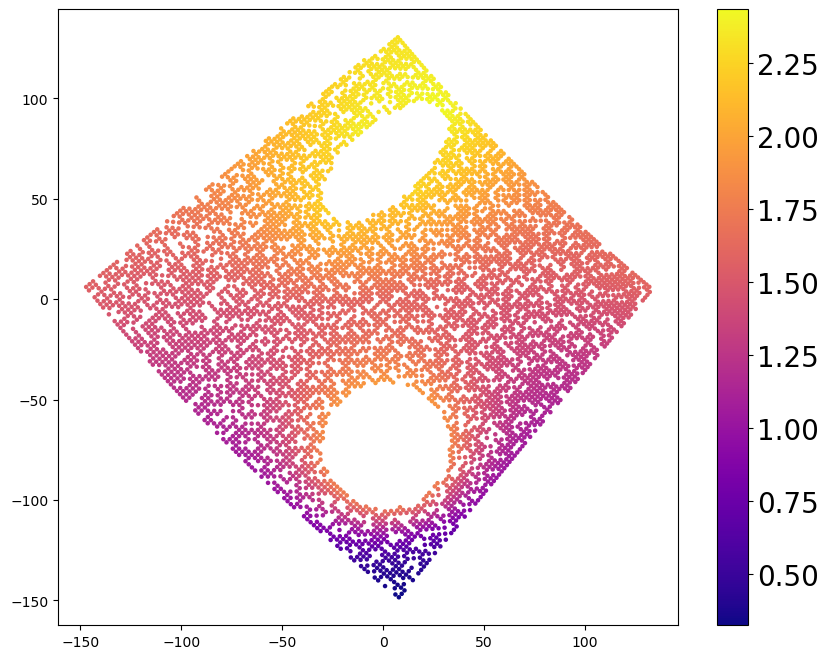

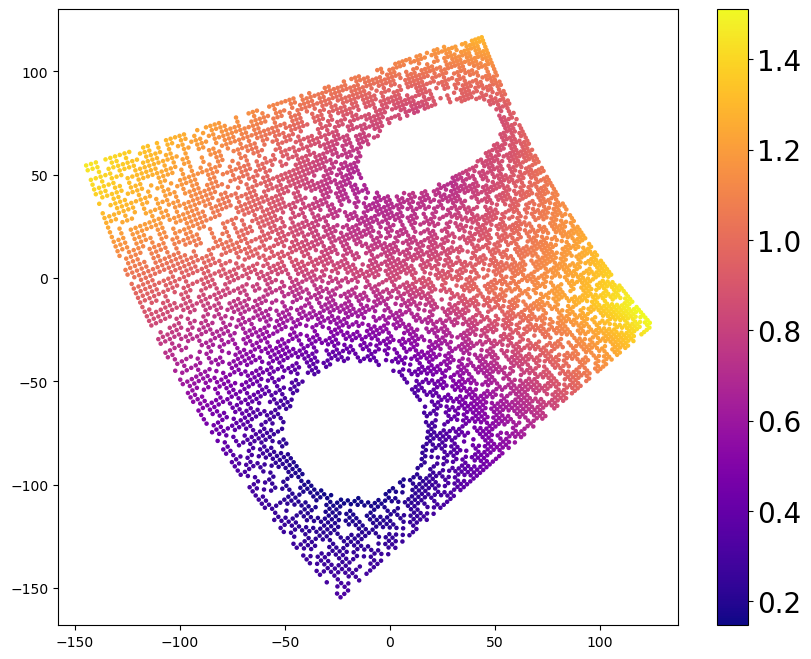

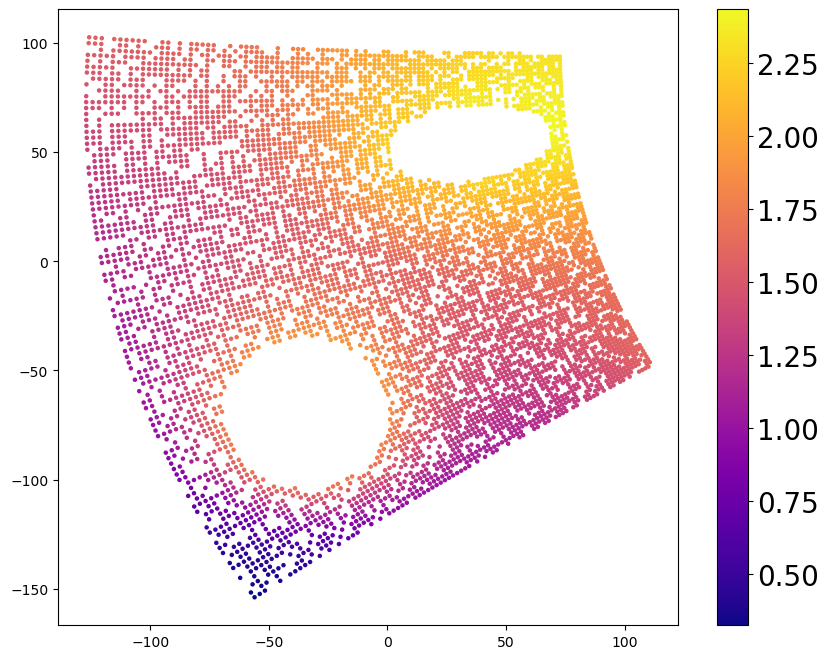

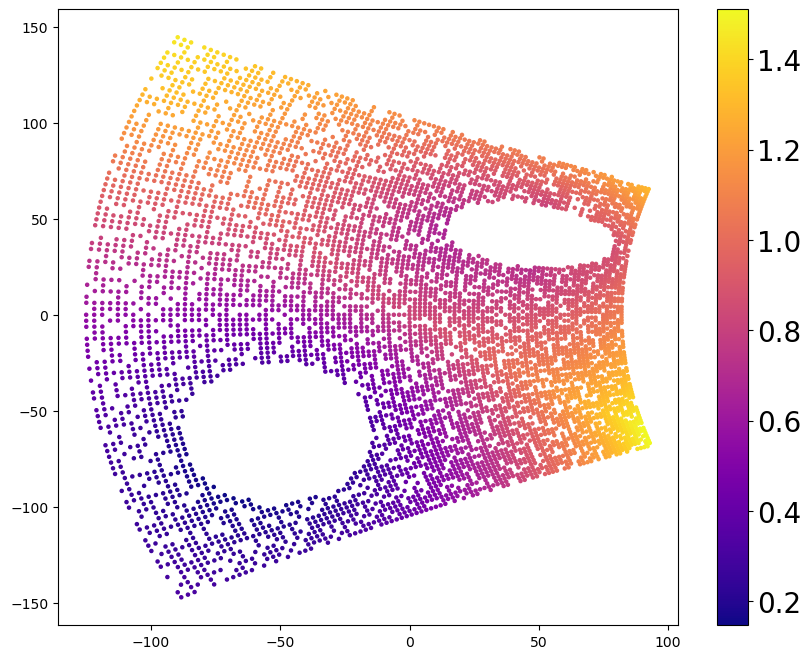

In [16]:
simulated_slices = {}

for h in range(5):
    a = 1
    b = .0005 * h
    c = .0005 * h
    d = 0.5

    # Apply the Möbius transform
    x_transformed, y_transformed = mobius_transform(points[:,0]-50, points[:,1]-50, a, b, c, d)

    if h % 2 == 0:
        colors = features_modality1.sum(axis=1)
        features = features_modality1
    else:
        colors = features_modality2.sum(axis=1)
        features = features_modality2
    
    spatial_coordinates = np.vstack((x_transformed,y_transformed)).T
    spatial_coordinates = rotate_points(spatial_coordinates, (4 - h) * 15)  # Apply global rotation
    slice_adata = anndata.AnnData(X=features)
    slice_adata.obsm['spatial'] = spatial_coordinates
    simulated_slices[h] = slice_adata

    # Plotting the transformed points
    plt.figure(figsize=(10, 8))
    plt.scatter(spatial_coordinates[:,0], 
                    spatial_coordinates[:,1], 
                    c=colors, cmap='plasma', s=5)
    colorbar = plt.colorbar()
    colorbar.ax.tick_params(labelsize=20)
    plt.show()
    


Now, let's plot all five slices in the same coordinate system. The slices are of different shapes and different angles.

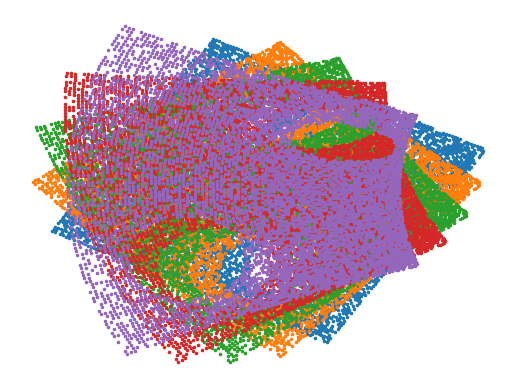

In [17]:
colors = {
    0:'#1f77b4',
    1:'#ff7f0e',
    2:'#2ca02c',
    3:'#d62728',
    4:'#9467bd'
}
plot_slices_overlap([simulated_slices[0].obsm['spatial'], simulated_slices[1].obsm['spatial'], simulated_slices[2].obsm['spatial'], simulated_slices[3].obsm['spatial'], simulated_slices[4].obsm['spatial']],colors=[colors[0],colors[1],colors[2],colors[3],colors[4]], invert_axis=False)


# Run MOSAICFlow physical alignment

Now, for each pair of adjacent slices, run MOSAICFlow to compute an affine transformation. Finally, register all slices onto the coordinate system of the last slice.

In [18]:
projected_coordinates = {0:{}}

for i in range(5 - 1):
    slice_1 = simulated_slices[i]
    slice_2 = simulated_slices[i+1]
    
    slice_1_aligned, slice_2_aligned, T_12, P_12 = physical_align(slice_1, slice_2, max_iter=10, alpha=0.1)
    
    projected_coordinates[i+1] = {i: slice_1_aligned.obsm['spatial']}
    
    for slice_idx in projected_coordinates[i]:
        X_sliceidx_proj = affine_transform(projected_coordinates[i][slice_idx],T_12)
        projected_coordinates[i+1][slice_idx] = X_sliceidx_proj
    

Iter: 0


/n/fs/ragr-research/users/xinhao/miniconda3/envs/dynamics/lib/python3.9/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Iter: 1
Iter: 2
Iter: 3
Iter: 4
Iter: 5
Iter: 6
Iter: 7
Iter: 8
Iter: 9
Iter: 0
Iter: 1
Iter: 2
Iter: 3
Iter: 4
Iter: 5
Iter: 6
Iter: 7
Iter: 8
Iter: 9
Iter: 0
Iter: 1
Iter: 2
Iter: 3
Iter: 4
Iter: 5
Iter: 6
Iter: 7
Iter: 8
Iter: 9
Iter: 0
Iter: 1
Iter: 2
Iter: 3
Iter: 4
Iter: 5
Iter: 6
Iter: 7
Iter: 8
Iter: 9


Let's visualize the registered slices in the same coordinate system.

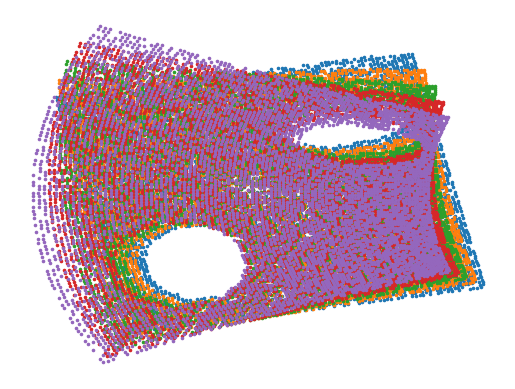

In [21]:
plot_slices_overlap([projected_coordinates[4][0],projected_coordinates[4][1],projected_coordinates[4][2],projected_coordinates[4][3], simulated_slices[4].obsm['spatial']],colors=[colors[0],colors[1],colors[2],colors[3],colors[4]], invert_axis=False)


Let's try the 3D plot:

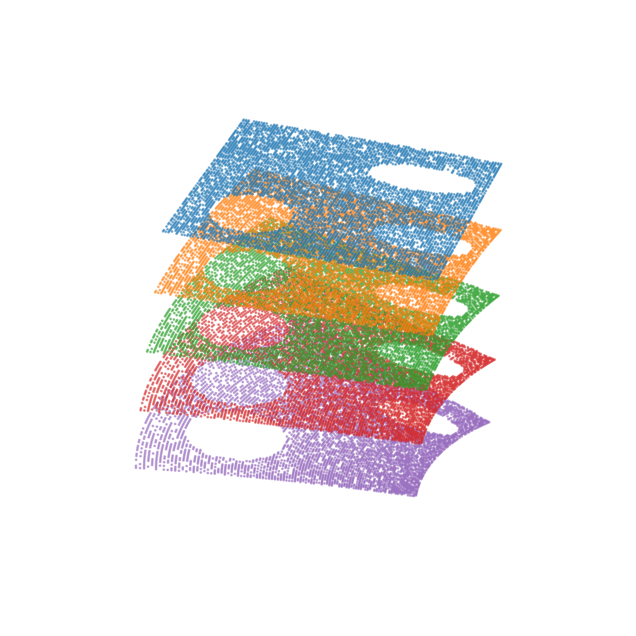

In [22]:
# Stack of 2D slices
slices = [projected_coordinates[4][0],projected_coordinates[4][1],projected_coordinates[4][2],projected_coordinates[4][3], simulated_slices[4].obsm['spatial']]

# Corresponding colors for each slice
colors = [colors[0],colors[1],colors[2],colors[3],colors[4]]

# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each slice at a different z-coordinate
for z, (slice_data, color) in enumerate(zip(slices, colors)):
    x = slice_data[:, 0]
    y = slice_data[:, 1]
    z_coord = 4 - z
    z_coords = np.full_like(x, z_coord)  # Set the z-coordinate for this slice
    ax.scatter(x, y, z_coords, color=color, label=f'Slice {z + 1}', alpha=0.5, s=1)

# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.legend()
ax.set_axis_off()

# Show the plot
plt.show()